In [32]:
import pandas as pd
import numpy as np
import xarray as xr
from scipy.stats import norm
import xclim
import xclim.indices as xc

from xclim.core.calendar import percentile_doy
from xclim.indices import standardized_precipitation_index
from xclim.indices import standardized_precipitation_evapotranspiration_index as spei

import calendar

from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rcParams



import cartopy.crs as ccrs
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import matplotlib.colors as mcolors
from scipy.ndimage import label

##Path

In [34]:
pet = r"/Volumes/arash /env/hadi/New Folder With Items/result/dataset_pet.csv"
pre = r"/Volumes/arash /env/hadi/New Folder With Items/result/dataset_pre.csv"

In [35]:
pet = pd.read_csv(pet)
pre = pd.read_csv(pre)

In [36]:
pet.head()

,Date,Value,Type
0,Jan 1901,1.5,Actual
1,Feb 1901,2.2,Actual
2,Mar 1901,3.4,Actual
3,Apr 1901,4.5,Actual
4,May 1901,5.7,Actual


In [37]:
pet = pet.rename(columns={'Value': 'pet'})
pre = pre.rename(columns={'Value': 'pre'})

In [38]:
data =pd.merge(pet, pre, on=['Date', 'Type'])

In [28]:
data.set_index('Date', inplace=True)

In [39]:
data.head().to_clipboard(index=False)

In [40]:
df = data.copy()

In [50]:
df["pre"] = pd.to_numeric(df["pre"], errors="coerce")
df["pet"] = pd.to_numeric(df["pet"], errors="coerce")

In [ ]:
days = df.index.days_in_month
pre_d = df["pre"] / days        
pet_d = df["pet"] / days        # mm/day
wb_d  = pre_d - pet_d           
wb_d.index.name = "time"

In [ ]:
wb_da = xr.DataArray(wb_d, name="wb")
wb_da.attrs["units"] = "mm d-1"  

In [54]:
SPEI_3 = spei(wb_da, window=3, dist="gamma", method="ML").to_series().rename("SPEI_3")


In [55]:
result = df.assign(SPEI_3=SPEI_3)

In [56]:
print(result)

                 pet      Type        pre    SPEI_3
time                                               
1901-01-01  1.500000    Actual  27.400000       NaN
1901-02-01  2.200000    Actual  21.100000       NaN
1901-03-01  3.400000    Actual  33.900000 -1.037833
1901-04-01  4.500000    Actual  25.400000 -0.805205
1901-05-01  5.700000    Actual  21.200000 -0.127059
...              ...       ...        ...       ...
2033-08-01  6.996954  Forecast   7.858404  2.370804
2033-09-01  5.562043  Forecast   5.380517  2.073430
2033-10-01  3.747502  Forecast   6.532415 -0.018918
2033-11-01  2.221721  Forecast  12.394634 -0.912837
2033-12-01  1.441353  Forecast  24.405046 -0.980382

[1596 rows x 4 columns]


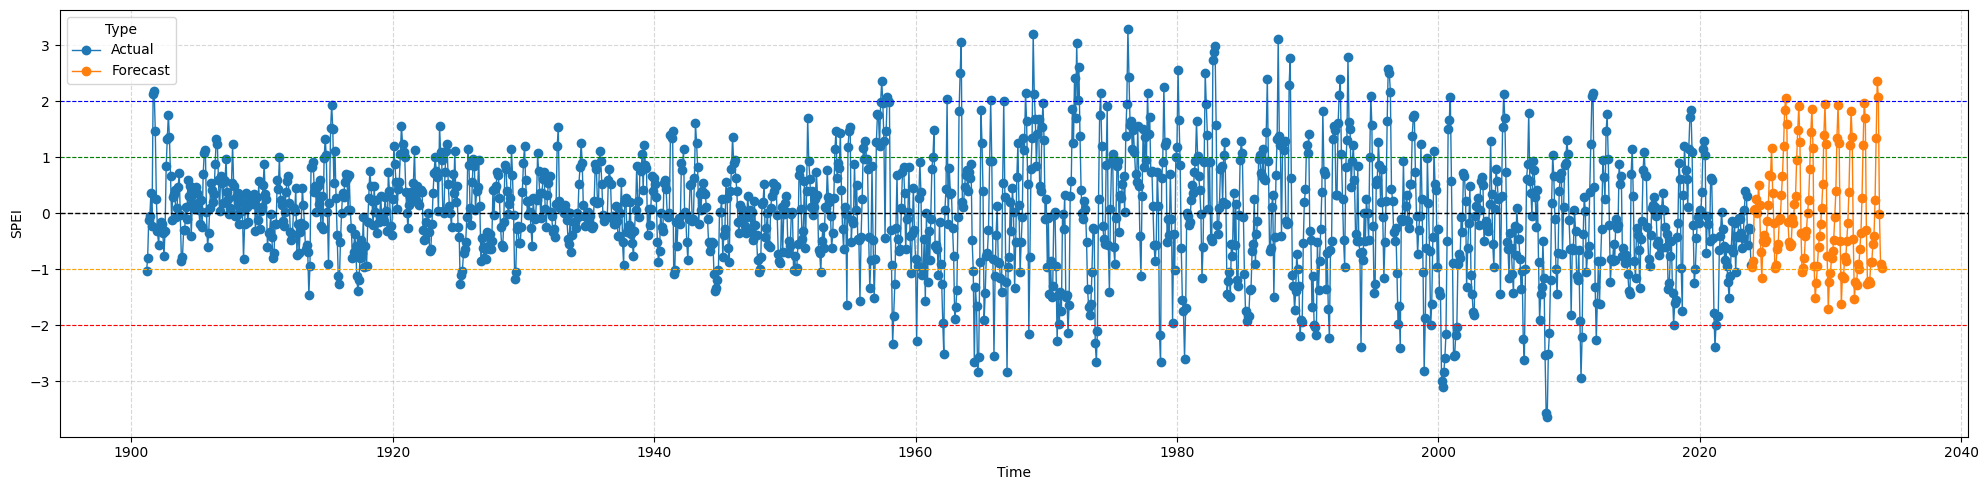

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))

for label, group in result.groupby("Type"):
    plt.plot(group.index, group["SPEI_3"], marker="o", linewidth=1, label=label)

# خطوط مرجع
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.axhline(-1, color="orange", linestyle="--", linewidth=0.8)
plt.axhline(-2, color="red", linestyle="--", linewidth=0.8)
plt.axhline(1, color="green", linestyle="--", linewidth=0.8)
plt.axhline(2, color="blue", linestyle="--", linewidth=0.8)

plt.xlabel("Time")
plt.ylabel("SPEI")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Type")
plt.tight_layout()
plt.show()


/var/folders/p8/26493lf52jx24t8650ypvkdw0000gn/T/ipykernel_76678/774718750.py:9: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  actual_last2y = actual_all.last("48M")
/var/folders/p8/26493lf52jx24t8650ypvkdw0000gn/T/ipykernel_76678/774718750.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  actual_last2y = actual_all.last("48M")


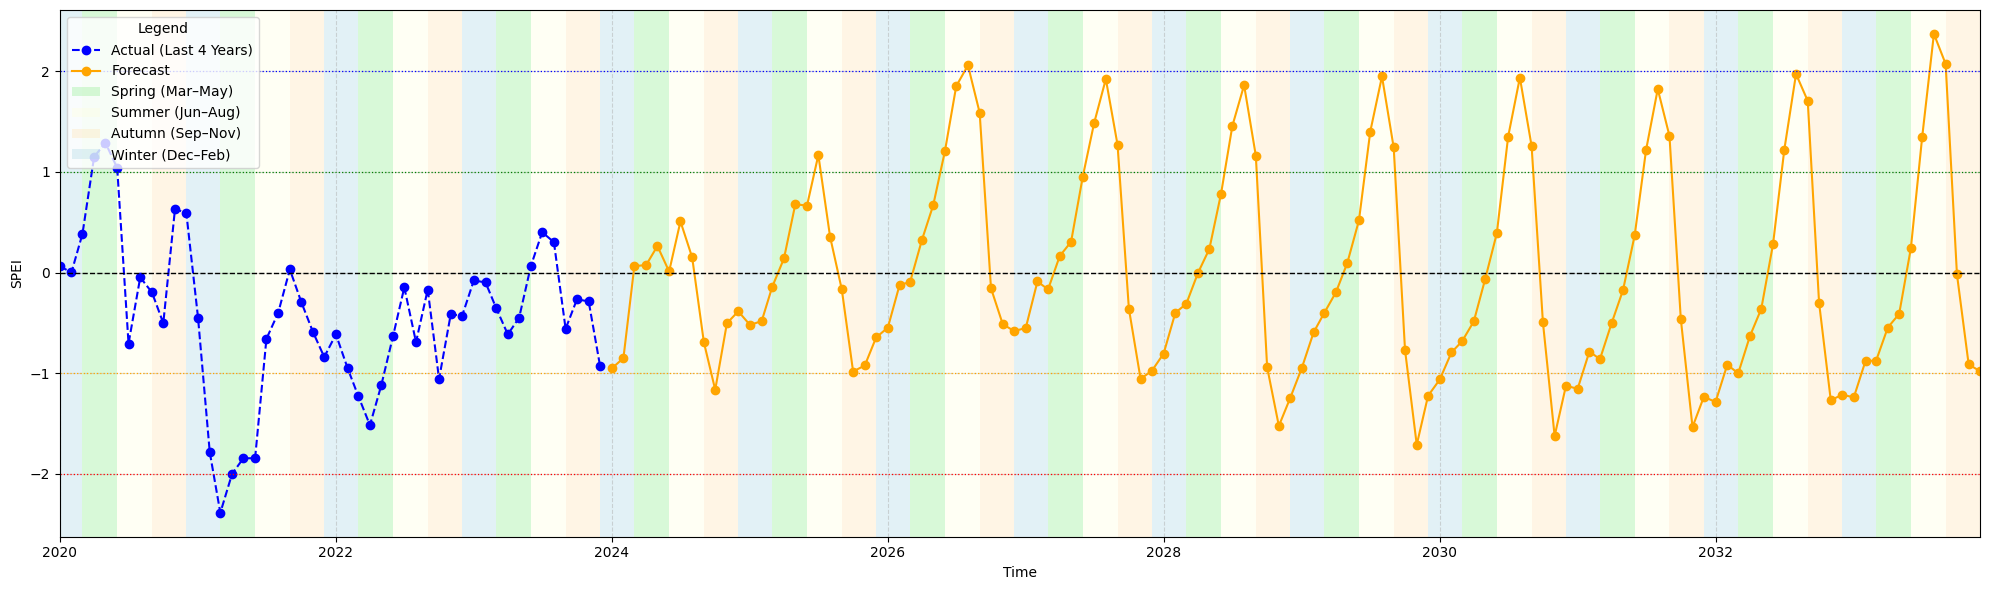

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

plt.figure(figsize=(20, 6))


actual_all = result[result["Type"] == "Actual"]
actual_last2y = actual_all.last("48M") 

forecast_all = result[result["Type"] == "Forecast"]

xmin = actual_last2y.index.min()
xmax = forecast_all.index.max() if not forecast_all.empty else actual_last2y.index.max()
plt.xlim(xmin, xmax)

line_actual, = plt.plot(
    actual_last2y.index, actual_last2y["SPEI_3"],
    linestyle="--", marker="o", linewidth=1.5, color="blue", label="Actual (Last 4 Years)"
)
line_fc, = plt.plot(
    forecast_all.index, forecast_all["SPEI_3"],
    linestyle="-", marker="o", linewidth=1.5, color="orange", label="Forecast"
)

plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.axhline(1, color="green", linestyle=":", linewidth=0.9)
plt.axhline(2, color="blue", linestyle=":", linewidth=0.9)
plt.axhline(-1, color="orange", linestyle=":", linewidth=0.9)
plt.axhline(-2, color="red", linestyle=":", linewidth=0.9)

# --- رنگ پس‌زمینه فصلی (پررنگ‌تر) ---
alpha_val = 0.35  # پررنگ‌تر از قبل
month_starts = pd.date_range(xmin, xmax + pd.offsets.MonthBegin(1), freq="MS")
for i in range(len(month_starts) - 1):
    start = month_starts[i]
    end = month_starts[i + 1]
    m = start.month
    if m in (3, 4, 5):       # Spring
        color = "lightgreen"
    elif m in (6, 7, 8):     # Summer
        color = "lightyellow"
    elif m in (9, 10, 11):   # Autumn
        color = "moccasin"
    else:                    # Winter
        color = "lightblue"
    plt.axvspan(start, end, facecolor=color, alpha=alpha_val)

plt.xlabel("Time")
plt.ylabel("SPEI")
plt.grid(True, linestyle="--", alpha=0.5)


season_handles = [
    Patch(facecolor="lightgreen", alpha=alpha_val, label="Spring (Mar–May)"),
    Patch(facecolor="lightyellow", alpha=alpha_val, label="Summer (Jun–Aug)"),
    Patch(facecolor="moccasin", alpha=alpha_val, label="Autumn (Sep–Nov)"),
    Patch(facecolor="lightblue", alpha=alpha_val, label="Winter (Dec–Feb)"),
]
plt.legend(handles=[line_actual, line_fc, *season_handles], title="Legend", loc="upper left")

plt.tight_layout()
plt.show()
